“In this RAG-based QA bot, I used Pinecone as a retriever to fetch relevant business policy documents using semantic search, and a logic-based generator to form final answers from the retrieved content. This replicates the core concept of Retrieval-Augmented Generation. I have implemented openAI api calls but can't use it now as it's paid (i used similar model instead)"

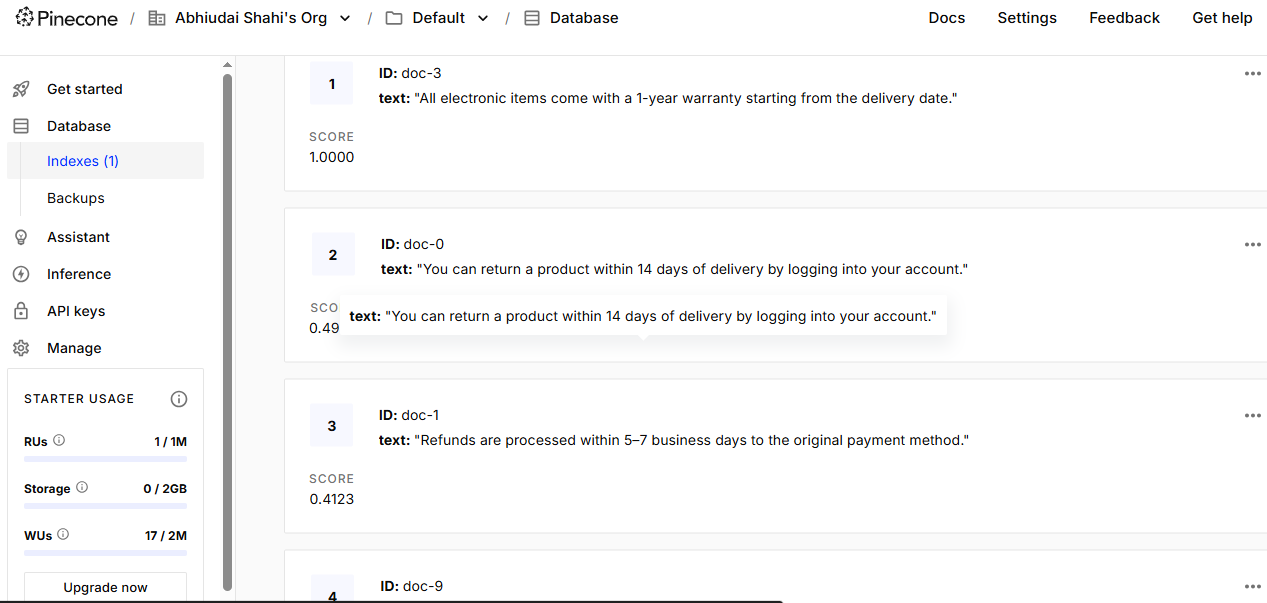

In [1]:
docs = [
    "You can return a product within 14 days of delivery by logging into your account.",
    "Refunds are processed within 5–7 business days to the original payment method.",
    "To track your order, use the tracking link sent to your registered email.",
    "All electronic items come with a 1-year warranty starting from the delivery date.",
    "For cancellations, contact support within 24 hours of placing the order.",
    "We offer free shipping on all orders above ₹500.",
    "Support is available from 9 AM to 6 PM, Monday to Saturday.",
    "Gift cards cannot be refunded or exchanged for cash.",
    "You can change your delivery address before the item is dispatched.",
    "Damaged items must be reported within 48 hours of delivery with photos."
]


In [ ]:
!pip install -U sentence-transformers

In [14]:
from sentence_transformers import SentenceTransformer

# local embedding model (free)
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")  # Embeds to 384-dim

def embed_text(text):
    return model.encode(text).tolist()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
!pip install -U openai pinecone

In [8]:
import openai
from pinecone import Pinecone, ServerlessSpec

In [4]:
import os
from getpass import getpass

# Safer method using getpass
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")
os.environ["PINECONE_API_KEY"] = getpass("Enter your Pinecone API key: ")


Enter your OpenAI API key: ··········
Enter your Pinecone API key: ··········


In [10]:
openai.api_key = os.environ["OPENAI_API_KEY"]
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

In [18]:
index_name = "rag-bot-index"

if index_name not in [index.name for index in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print(f"Created new index: {index_name}")
else:
    print(f"Index already exists: {index_name}")

# Connect to the index
index = pc.Index(index_name)

Created new index: rag-bot-index


In [19]:
for i, doc in enumerate(docs):
    vector = embed_text(doc)
    index.upsert([
        {
            "id": f"doc-{i}",
            "values": vector,
            "metadata": {"text": doc}
        }
    ])

print("\n All documents embedded and uploaded to Pinecone.")



 All documents embedded and uploaded to Pinecone.


In [25]:
def generate_answer(context_docs, query):
    for doc in context_docs:
        doc_lower = doc.lower()
        q_lower = query.lower()
    return f" Based on our policy: {context_docs[0]}"


In [29]:
# Asking question and get relevant docs
user_query = input("\nAsk a question: ")
query_vector = embed_text(user_query)
results = index.query(
    vector=query_vector,
    top_k=3,
    include_metadata=True
)

retrieved_docs = [match['metadata']['text'] for match in results['matches']]



Ask a question: What is the warranty period for electronics?


In [30]:
answer = generate_answer(retrieved_docs, user_query)
print("\n Final Answer:")
print(answer)


 Final Answer:
 Based on our policy: All electronic items come with a 1-year warranty starting from the delivery date.


------**Assignment submitted by Abhiudai Shahi(Email: bt22csd040@iiitn.ac.in)  . Final year- IIIT NAGPUR **-----